# Import modules

In [ ]:
# %%file animal_cls_modules.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

import time
import datetime
import os
import copy
import PIL
import cv2
from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import shutil
import glob
from zipfile import ZipFile
import seaborn as sns
import pandas as pd
import numpy as np
import random
import h5py
from tqdm import tqdm
from dataclasses import dataclass


plt.style.use("fivethirtyeight")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Working on device= {device}')

torch.set_printoptions(linewidth=120)
torch.cuda.empty_cache()
print()

if str(device) == 'cuda':
  print(torch.cuda.get_device_name(torch.cuda.current_device()))
  print(f"torch: {torch.__version__}")

Working on device= cuda

Tesla T4
torch: 1.13.1+cu116


In [ ]:
!pip install torchmetrics --quiet
!pip install torchinfo --quiet
!pip install torchviz --quiet

!pip install typing-extensions --quiet
!pip install wheel --quiet

# !pip install mlflow --quiet
# !pip install pyngrok --quiet
!pip install wandb

import torchmetrics
from torchmetrics import MetricCollection

from torchinfo import summary
from torchviz import make_dot

# from pyngrok import ngrok
# import mlflow
# import mlflow.sklearn
# import mlflow.pytorch
# from mlflow import log_metric, log_param, log_artifacts
# from mlflow.tracking import MlflowClient
import wandb

# Classes preparing

## DataWrangling

In [ ]:
# %%file data_wrangling.py

class DataWrangling:

  def __init__(self, path_to_zip_file):
    self.path_to_zip_file = path_to_zip_file
    self.data_names = {'train' : None, 'val' : None, 'test' : None }   
    self.base_dir = 'new_dataset'

  def extract_archive(self):
    with ZipFile( self.path_to_zip_file, 'r') as zipobj:
      zipobj.extractall(path='data/')
      zipobj.close()

  
  def __get_labels(self, dir_path):
    label_names_file = os.path.join(dir_path, 'label_names.txt')

    with open(label_names_file, "r") as myFile:
      self.class_names = myFile.read().splitlines() 

  def __move_files_to_folder(self, data_list, src_path, dst_path):
    for item in data_list:
      shutil.copy(os.path.join(src_path, item), dst_path)      # shutil.move     

  def __create_directories(self):
    '''base_dir
        images
          train
          validation
          test
    '''
    self.datasets_path = os.path.join('datasets', self.base_dir)
    os.makedirs(self.datasets_path, exist_ok=True)
 
    for d_name in self.data_names.keys():
      dir = os.path.join(self.datasets_path, d_name)
      os.mkdir(dir)
      print(f"create {dir}")  
      if d_name != 'test':
        for i, cls in enumerate(self.class_names):
          train_cls = os.path.join(dir, cls)
          os.mkdir(train_cls)
      else:
        subtest = os.path.join(dir, 'test')
        os.mkdir(subtest)

  
  def __create_splitting_lists(self, imgs): # size = 0.1
    self.train_images, self.val_images = train_test_split(imgs,  test_size=self.val_size, random_state=1)
    self.val_images, self.test_images = train_test_split(self.val_images, test_size=self.test_size, random_state=1) # 0.05

    self.data_names['train'] = self.train_images
    self.data_names['val'] = self.val_images
    self.data_names['test'] = self.test_images


  def split_data(self, data_dir_path, val_size, test_size):
    self.val_size = val_size
    self.test_size = test_size
    
    self.__get_labels(dir_path= data_dir_path)
    self.__create_directories()

    # self.imgs_path = os.path.join(data_dir_path, 'images')
    # self.base_dir_path = os.path.join('/content', self.datasets_path)

    print()
    # print(f"imgs path: {self.imgs_path}")
    print()
    print(f"Splitting dataset to train, val and test data...")
    print()
    print(f"val dataset - {int(self.val_size*100)}% train dataset")
    print(f"test dataset - {int(self.test_size*100)}% validation dataset")
    print()

    for i, cls in enumerate(self.class_names):
      animal_img = os.path.join(data_dir_path, 'images', cls)
      images = os.listdir( animal_img ) 

      self.__create_splitting_lists(images)

      for d_name, splitted_list in self.data_names.items():
        if d_name != 'test':
          img_data_dir = os.path.join(self.datasets_path, d_name, cls)
          self.__move_files_to_folder(splitted_list, animal_img, img_data_dir)
        else:
          img_test_dir = os.path.join(self.datasets_path, d_name, 'test') 
          self.__move_files_to_folder(splitted_list, animal_img, img_test_dir) 

    
    nb_train_data = len(self.data_names['train'])
    nb_val_data = len(self.data_names['val'])
    nb_test_data = len(self.data_names['test'])

    print(f"train: {nb_train_data*len(self.class_names)}, val: {nb_val_data*len(self.class_names)}, test: {nb_test_data*len(self.class_names)}")  
    print(f"train: {nb_train_data}, val: {nb_val_data}, test: {nb_test_data} for each class")  

    new_dataset_name = f"ValSize_{int(self.val_size*100)}_TestSize_{int(self.test_size*100)}"
    # f"train_{nb_train_data*len(self.class_names)}_val_{nb_val_data*len(self.class_names)}_test_{nb_test_data*len(self.class_names)}"
    os.rename(src= self.datasets_path, dst= os.path.join(self.datasets_path.split('/')[0], new_dataset_name))
                                                        
  def data_count(self, path):
    for self.entry in os.scandir( path= path ):
      if self.entry.is_dir():
        self.files_gen = ( self.image for self.image in os.listdir( self.entry.path ) )
        self.files_count = len( [ self.image for self.image in self.files_gen] )
        print( self.entry.name, self.files_count )

        if self.files_count >= 1:
          DataWrangling.data_count( self, path=self.entry.path )
      # print('-'*50)
         

  def connect_transformer_to_dataset(self, data_dir, transform_dict ):
    self.image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), transform_dict[x]) for x in ['train', 'val', 'test']}
    self.dataset_sizes = {x: len( self.image_datasets[x]) for x in ['train', 'val', 'test']}

    print(f'dataset sizes: { self.dataset_sizes}')
    

  def create_dataloaders(self, batch_size):
    self.dataloaders = { x: DataLoader(self.image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']} 
    

## ImagePreprocessing

In [ ]:
# %%file image_preprocessing.py

class ImagePreprocessing:

  def __init__(self, dir_path):
    self.dir_path = dir_path
    self.counter = 0
    self.mean_std_dict = {} 

  def _get_dir_name_from_path(self, path):
    self.last_slash_idx        = path.rfind('/')
    self.dir_name              = path[ self.last_slash_idx + 1: ]
    return self.dir_name    

  def _create_files_generator(self, class_name=None):
    if class_name != None:
      self.path = os.path.join( self.dir_path, class_name )
    else: 
      self.path = os.path.join( self.dir_path)
    self.files_gen = ( self.image for self.image in os.listdir( self.path ) )
    return self.files_gen  

  def _open_image_file(self, img):
    self.image_path = os.path.join( self.path, img )
    self.image = cv2.imread( self.image_path, cv2.IMREAD_UNCHANGED )
    self.image = cv2.cvtColor( self.image, cv2.COLOR_BGR2RGB)
    
  def __image_size_of_one_class(self, class_name):
    self.files_gen = self._create_files_generator( class_name )
    self.image = next( self.files_gen )
    self._open_image_file( self.image )
    self.height, self.weight, _ = self.image.shape
    self.im_resolution = self.height, self.weight
    print(f'{self.i}: {self.class_name}: {self.im_resolution}')
  
  def image_size_of_each_class(self):
    self.dir_name= self._get_dir_name_from_path( path=self.dir_path )
    self.class_names_list = os.listdir(self.dir_path)   
    print(f'Sizes of images in each class in { self.dir_name} data:')
    for self.i, self.class_name in enumerate( self.class_names_list):
      self.__image_size_of_one_class( self.class_name )
   
  def _get_image_channels_as_array(self):
      self._open_image_file( self.image )
      self.r_array, self.g_array, self.b_array  =  cv2.split( self.image )
      # convert to matrix
      # self.r_array, self.g_array, self.b_array  = np.asarray(self.r), np.asarray(self.g), np.asarray(self.b)
      return self.r_array, self.g_array, self.b_array 

  def _convert_to_float(self):
      # convert from int to float  'float32'
      self.r_array, self.g_array, self.b_array = self.r_array.astype(np.float32), self.g_array.astype(np.float32), self.b_array.astype(np.float32)
      return self.r_array, self.g_array, self.b_array 

  def _normalize(self):
      # normalize to the range 0-1
      self.r_array /= 255.0
      self.g_array /= 255.0
      self.b_array /= 255.0
      return self.r_array, self.g_array, self.b_array 

  def __calculate_mean_and_std(self):
      # calculate mean
      self.r_array_mean, self.g_array_mean, self.b_array_mean = np.mean( self.r_array ), np.mean( self.g_array ), np.mean( self.b_array )
      # calculate std
      self.r_array_std, self.g_array_std, self.b_array_std = np.std( self.r_array ), np.std( self.g_array ), np.std( self.b_array )

  def __append_to_data_frame(self):
      self.mean_std_dict['image'] = self.image_name,
      self.mean_std_dict['R_mean'], self.mean_std_dict['G_mean'], self.mean_std_dict['B_mean'] = self.r_array_mean, self.g_array_mean, self.b_array_mean, 
      self.mean_std_dict['R_std'],  self.mean_std_dict['G_std'],  self.mean_std_dict['B_std']  = self.r_array_std,  self.g_array_std,  self.b_array_std  
                    
      self.df = self.df.append( pd.DataFrame(self.mean_std_dict, index=[0] ))     

  def get_mean_and_std_images(self, class_name ):
    self.df = pd.DataFrame() 
    self.files_gen = self._create_files_generator( class_name )
    for self.image in self.files_gen:
      self.image_name = self.image
      self._get_image_channels_as_array()
      self._convert_to_float()
      self._normalize()
      self.__calculate_mean_and_std()
      self.__append_to_data_frame()
    self.df.reset_index( drop=True, inplace=True )
    return self.df

  def visualize_n_random_images( self, number_of_images, no_rows, no_cols, set_figsize, save_to_path,  class_name=None, pred_dict=None):
    self.i = 1
    self.images_no = number_of_images
    self.cols = no_cols
    self.rows = no_rows
    self.files_gen = self._create_files_generator( class_name=class_name ) 
    self.random_images = random.choices( list(self.files_gen), k=self.images_no )
    self.pred_dict = pred_dict

    fig = plt.figure( figsize= set_figsize )
    for self.image in self.random_images:
      if self.pred_dict != None and self.image in self.pred_dict:
        self.image_name = self.pred_dict[self.image]
        if self.image_name in self.image:
          self.set_color = 'green'
        else:
          self.set_color = 'red'
      else:
        self.image_name = self.image
        self.set_color = 'black'

      self.ax = fig.add_subplot( self.rows, self.cols, self.i)      
      self._open_image_file( self.image )
      plt.imshow( self.image )  
      plt.axis('off')
      self.ax.set_title( self.image_name, color=self.set_color, fontweight='bold', fontsize=12)
      
      self.i+=1

    plt.tight_layout()
    plt.savefig( save_to_path )

## TrainModel

In [ ]:
@dataclass
class TrainModelItems:
  myBar_format  = '{l_bar}{bar:15}{r_bar}{bar:-15b}'
  metrics_df = pd.DataFrame()
  results_dict = {}
  metrics_dict = {}
  
  start      = torch.cuda.Event(enable_timing=True)
  end        = torch.cuda.Event(enable_timing=True)

  epochs_list,                train_loss_list,          val_loss_list                                  = [], [], []
  train_acc_list,             val_acc_list,             train_acc_macro_list,    val_acc_macro_list    = [], [], [], []  
  train_f1_macro_list,        val_f1_macro_list,                                                       = [], []   
  train_precision_macro_list, val_precision_macro_list, train_recall_macro_list, val_recall_macro_list = [], [], [], []    

  results_dict['epoch']                                                      = epochs_list
  results_dict['train_loss'],            results_dict['val_loss']            = train_loss_list,            val_loss_list
  results_dict['train_acc'],             results_dict['val_acc']             = train_acc_list,             val_acc_list     
  results_dict['train_acc_macro'],       results_dict['val_acc_macro']       = train_acc_macro_list,       val_acc_macro_list     
  results_dict['train_f1_macro'],        results_dict['val_f1_macro']        = train_f1_macro_list,        val_f1_macro_list
  results_dict['train_precision_macro'], results_dict['val_precision_macro'] = train_precision_macro_list, val_precision_macro_list 
  results_dict['train_recall_macro'],    results_dict['val_recall_macro']    = train_recall_macro_list,    val_recall_macro_list

  
  metrics_dict['acc'] = torchmetrics.Accuracy( num_classes=21, average='macro', task="multiclass" ).to(device)
  metrics_dict['f1']  = torchmetrics.F1Score( num_classes=21, average='macro', task="multiclass" ).to(device)
  metrics_dict['precision'] = torchmetrics.Precision( num_classes=21, average='macro', task="multiclass" ).to(device)
  metrics_dict['recall'] = torchmetrics.Recall( num_classes=21, average='macro', task="multiclass" ).to(device)

  metric_collection = MetricCollection(metrics_dict)

In [ ]:
# %%file train_model.py
class TrainModel(TrainModelItems, ImagePreprocessing):
  
  def __init__(self, model, criterion, optimizer, lr_scheduler, num_epochs, dataloaders, dataset_sizes, class_names, device):
    self.dataloaders   = dataloaders
    self.dataset_sizes = dataset_sizes
    self.class_names   = class_names
    self.model         = model
    self.criterion     = criterion
    self.optimizer     = optimizer
    self.num_epochs    = num_epochs
    self.device        = device
    self.lr_scheduler  = lr_scheduler 

    self.config_dict   = {}
    self.config_dict["architecture"] = self.model.model_arch
    self.config_dict["epochs"]       = self.num_epochs
    self.config_dict["batch_size"]   = self.dataloaders['train'].batch_size
    self.config_dict["optimizer"]    = type(self.optimizer).__name__
    self.config_dict["criterion"]    = type(self.criterion).__name__
    self.config_dict["initial_lr"]   = self.optimizer.state_dict()['param_groups'][0]['initial_lr']
    
    self.wandb_metrics = {}

                                         
  def __set_model_phase(self):
    if self.phase == 'train':
      self.model.train()  # Set model to training model
    else:
      self.model.eval()   # Set model to evaluate model


  def _show_img_preds_for_epoch(self):
    if self.i == len( self.dataloaders[self.phase] ) - 2:
      imgs_no = 0
      for image, label, prediction in zip( self.inputs, self.labels, self.outputs):
        self.image = image.detach().cpu()

        self.image = self.image.permute(1, 2, 0).numpy()
        self.image = cv2.normalize(self.image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  
        pred_tensor = F.softmax(prediction, dim=0)
        pred_label_idx = int(torch.argmax( pred_tensor ).cpu().numpy() )

        class_name = 'pred: {}'.format( self.class_names[ pred_label_idx ])
        true_target = 'target: {}'.format( self.class_names[label] )
        pred_classes = "\n".join(["class {}: {}".format( self.class_names[i], pred) for i, pred in enumerate(pred_tensor)])
        description = f"{true_target} \n{pred_classes}"
            
        # run["monitoring/preds/{}/epoch_{}".format( self.phase, self.epoch)].log(
        #                                                                   neptune.types.File.as_image( self.image ),
        #                                                                   name= class_name,
        #                                                                   description=description
        #                                                                   )            
        if imgs_no == 28: #20
          break
        imgs_no += 1       

  def __backpropagation_algorithm(self):
    # forward
    with torch.set_grad_enabled( self.phase == 'train'): 
      self.optimizer.zero_grad()
      self.outputs = self.model(self.inputs)
      self.loss = self.criterion( self.outputs, self.labels)
      self.y_preds_indices = torch.argmax(self.outputs, dim=1) # Returns the indices of the maximum value of all elements in the input tensor.
                                                               # This is the second value returned by torch.max().
      # backward and update weights only if in training phase
      if self.phase == 'train': 
        self.loss.backward() # calculate gradients
        self.optimizer.step() # update weights
    return self.loss, self.y_preds_indices

  def __loop_over_phase(self, save_metrics):
    # Each epoch has a training and validation phase
    for self.phase in self.dataloaders.keys():
      self.n_batches = len(self.dataloaders[self.phase])   
      self.running_loss = 0.0
      self.running_corrects = 0
      self.__set_model_phase()

      # Iterate over data.
      for self.i, self.data in tqdm( enumerate( self.dataloaders[self.phase], 0 ), total=self.n_batches, bar_format=self.myBar_format ):
        self.inputs, self.labels = self.data
        self.inputs = self.inputs.to(self.device)
        self.labels = self.labels.to(self.device)
        # back propagation
        self.__backpropagation_algorithm()
        # self._show_img_preds_for_epoch()

        # statistics
        self.running_loss += self.loss.item() * self.inputs.size(0)
        self.running_corrects += torch.sum( self.y_preds_indices == self.labels.data ).item() 
        self.metric_collection(self.y_preds_indices, self.labels)

      self.epoch_loss = self.running_loss / self.dataset_sizes[self.phase]
      self.epoch_accuracy = (self.running_corrects / self.dataset_sizes[self.phase] )
      self.overall_metrics = self.metric_collection.compute()
      self.overall_metrics["loss"] = self.epoch_loss # -------------
     
      # wandb.log({f"{self.phase} Precision vs Recall" : wandb.plot.pr_curve(self.labels, self.y_preds_indices, labels=cls_names)})
      # wandb.log({f"{self.phase} ROC" : wandb.plot.roc_curve(self.labels, self.y_preds_indices, labels=cls_names)})
      # wandb.log({f"{self.phase} Confusion Matrix" : wandb.plot.confusion_matrix(preds=self.y_preds_indices, y_true=self.labels, class_names=cls_names)})

      # print(f'{self.phase} - Loss: {self.epoch_loss:.5f}, epoch_acc: {self.epoch_accuracy:.5f} last lr: {self.lr_scheduler.get_last_lr()[0]}' ) 
      print(f"{'Phase':<10} {'Loss':<10} {'Acc':<10} {'F1':<10} {'Precision':<10} {'Recall':<10} {'last lr':<10}")
      print(f"{self.phase:<10} {self.overall_metrics['loss']:<10.5f} {self.overall_metrics['acc']:<10.5f} {self.overall_metrics['f1']:<10.5f} {self.overall_metrics['precision']:<10.5f} {self.overall_metrics['recall']:<10.5f} {self.lr_scheduler.get_last_lr()[0]:<10.5f}") 

      if save_metrics == True:
        self.__metrics_saving()
        self.__monitor_metrics()
      self.metric_collection.reset()
      print()
          
  
  def __monitor_metrics(self):  
    self.wandb_metrics["epoch"] = self.epoch

    for name, metric in self.overall_metrics.items():
      self.wandb_metrics[f"Charts/{self.phase}_{name}"] = metric
    wandb.log(self.wandb_metrics)
  


  def __metrics_saving(self):

    # if self.phase == 'train':
    #   self.train_loss_list.append(self.epoch_loss)

    #   self.train_acc_list.append(self.epoch_accuracy)
    #   self.train_acc_macro_list.append(self.overall_metrics['acc'].item())     
    #   self.train_f1_macro_list.append( self.overall_metrics['f1'].item() )                   
    #   self.train_precision_macro_list.append( self.overall_metrics['precision'].item() )    
    #   self.train_recall_macro_list.append( self.overall_metrics['recall'].item())                    
    # else:
    #   self.val_loss_list.append(self.epoch_loss)

    #   self.val_acc_list.append(self.epoch_accuracy)
    #   self.val_acc_macro_list.append(self.overall_metrics['acc'].item())       
    #   self.val_f1_macro_list.append( self.overall_metrics['f1'].item() )                  
    #   self.val_precision_macro_list.append( self.overall_metrics['precision'].item() )     
    #   self.val_recall_macro_list.append( self.overall_metrics['recall'].item() )    
                    
      if self.epoch_accuracy  > self.best_accuracy:
        self.best_accuracy = self.epoch_accuracy 
      

  def __metrics_to_df(self):
    print('Saving to data frame...')
    metrics_dataframe = self.run.history()
    metrics_dataframe.to_csv("/content/metrics.csv")

    # self.metrics_df = pd.DataFrame.from_dict(self.results_dict)    
    # self.metrics_df.reset_index(drop=True, inplace=True)

    # self.metrics_df.to_csv('/content/metrics.csv') 

  def train_model(self, save_metrics=True):
    self.wandb_run = wandb.init(project="AnimalClassification_PyTorch", config= self.config_dict )
    with self.wandb_run as self.run:
      print()
      for key, val in self.config_dict.items():
        print(f"{key}: {val}")
      print()
      self.best_accuracy = 0.0
      torch.cuda.synchronize()
      self.start.record()
      for self.epoch in range( self.num_epochs):
        self.epochs_list.append( self.epoch + 1 )
        print(f'Epoch {self.epoch}/{ self.num_epochs - 1}')
        print('-' * 60)
        self.__loop_over_phase( save_metrics )
        self.lr_scheduler.step() 
      self.end.record()
      # Waits for everything to finish running
      torch.cuda.synchronize()
      self.time_elapsed = self.start.elapsed_time(self.end)

      # self.__metrics_to_df()
      print(f'Training complete in {str( datetime.timedelta(milliseconds=self.time_elapsed ) )}')
      print('Best val Acc: {:4f}'.format(self.best_accuracy))

      wandb.run.summary["best_accuracy"] = self.best_accuracy 

## Test model

In [ ]:
# %%file model_testing.py

class ModelTesting( ImagePreprocessing, DataWrangling ):
  
  def __init__(self, dir_path, data_loader, class_names, data_size):
    super().__init__( dir_path )
    self.data_loader = data_loader
    self.class_names = class_names
    self.data_size = data_size
    self.dir_path = dir_path
 

  def check_accuracy(self):
    correct = 0
    total = 0
    with torch.no_grad():
      for data in self.data_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        self.acc = ( correct / total ) * 100 
    print(f'Accuracy of the network on the {self.data_size} val images: {self.acc:.3f}%')

  def __create_true_pred_lists(self):
    self.y_pred = []
    self.y_true = []

    # iterate over test data
    for inputs, labels in self.data_loader:
      inputs = inputs.to(device)
      output = model(inputs) # Feed Network

      output = (torch.max(torch.exp(output), 1)[1]).cpu().data.numpy()
      self.y_pred.extend(output) # Save prediction
              
      labels = labels.cpu().data.numpy()
      self.y_true.extend(labels) # Save True val

  def create_confusion_matrix(self, figsize=(8, 5)):
    self.__create_true_pred_lists()

    # Build confusion matrix
    cm = confusion_matrix( self.y_true, self.y_pred)

    plt.figure(figsize=figsize)
    self.cm_image = sns.heatmap( cm, annot=True, fmt='d', linewidth=.2, cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names, annot_kws={"size": 15})
    self.cm_image.tick_params(labelsize=15)
    self.cm_image.xaxis.tick_top()
    plt.yticks(rotation=0) 
    plt.xticks(rotation=20)   
    plt.title(f'Accuracy of the network on the {self.data_size} val images: {self.acc:.3f}%' )

    self.cm_image = self.cm_image.get_figure()
    plt.tight_layout()
    plt.show()

  def __predict_one_image(self, img_path, transformer):  
    image=PIL.Image.open(img_path)
      
    image_tensor=transformer(image).float()
    image_tensor=image_tensor.unsqueeze_(0)
    input=Variable(image_tensor)
    input = input.to(device)
        
    output_tensor = model(input)
    predicted_values_tensor = output_tensor.data
    predicted_values_ndarray = predicted_values_tensor.cpu().data.numpy()
    index_of_max_values = predicted_values_ndarray.argmax()
    predicted_label=self.class_names[index_of_max_values] 

    return predicted_label   
     

  def model_testing(self ):
    self.pred_dict={}
    images_pathes = glob.glob( os.path.join( self.dir_path, '*.jpg') )

    for self.img_path in images_pathes:
      self.dir_name = super()._get_dir_name_from_path( path=self.img_path, )
      predicted_class       = self.__predict_one_image(self.img_path, transformer=data_transforms['test'])
      self.pred_dict[ self.dir_name ] = predicted_class  

## Models

### ConvNet

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, in_channels, n_classes, model_arch):
    super(ConvNet, self).__init__()
    self.in_channels = in_channels
    self.model_arch = model_arch
    self.conv_layers = self.create_conv_layers( self.model_arch)  
    self.dropout = nn.Dropout(p=0.2)

    self.fcs = nn.Sequential(
        nn.Linear(int( self.model_arch[-1])*18*18, 6912), # 256 - number of channels after convlution, # 6912, 4096
        nn.ReLU(),                                        # 7*7 - image shape: beginning image shape 150 -> 150/2**maxpool -> 150/(2**3)=18                             
        nn.Linear(6912, 4096),
        nn.ReLU(),
        # nn.Linear(4096, 512),
        # nn.ReLU(),
        nn.Linear(4096, n_classes)
    )                            

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.reshape(x.shape[0], -1) # flatten
    x = self.fcs(x)
    # x = self.dropout
    return x

  def create_conv_layers(self, architecture): 
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == int:
        out_channels = x

        layers += [
                   nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=(1,1), padding=(1,1)),  
                   nn.BatchNorm2d(num_features=out_channels),    
                   nn.ReLU()
                   ]
        in_channels = x 

      elif x == 'MaxPool':
        layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

    return nn.Sequential(*layers) # unpacking layers list


# Instances

In [ ]:
# from image_preprocessing import ImagePreprocessing
path_to_zip = '/content/drive/MyDrive/ColabNotebooks/Projects/AnimalsDetection/animal_dataset_258.zip'

data_wrangling_obj = DataWrangling( path_to_zip )

# Data wrangling

## Unpacking data

In [ ]:
data_wrangling_obj.extract_archive()

## Move files to specific folders

In [ ]:
unpacked_data_dir = "/content/data/animal_dataset_258"

data_wrangling_obj.split_data( data_dir_path=unpacked_data_dir, val_size=0.2, test_size=0.02 )

create datasets/new_dataset/train
create datasets/new_dataset/val
create datasets/new_dataset/test


Splitting dataset to train, val and test data...

val dataset - 20% train dataset
test dataset - 2% validation dataset

train: 4326, val: 1050, test: 42
train: 206, val: 50, test: 2 for each class


In [ ]:
my_datasets_path = "/content/datasets"
datasets_list = os.listdir(my_datasets_path)
myDataset = os.path.join(my_datasets_path, datasets_list[0])

datasets_list

['ValSize_20_TestSize_2']

In [ ]:
data_wrangling_obj.data_count( path=myDataset )

test 1
test 42
train 21
lis 206
dzik 206
Kos 206
Kwiczol 206
Dzieciol_duzy 206
Szpak 206
borsuk 206
Sikorka_bogatka 206
wilk 206
jelen_szlachetny 206
Rudzik 206
sroka 206
Dzwoniec 206
sojka 206
Sierpowka 206
sarna 206
kawka 206
wiewiorka 206
gil 206
Wrobel_domowy 206
Raniuszek 206
val 21
lis 50
dzik 50
Kos 50
Kwiczol 50
Dzieciol_duzy 50
Szpak 50
borsuk 50
Sikorka_bogatka 50
wilk 50
jelen_szlachetny 50
Rudzik 50
sroka 50
Dzwoniec 50
sojka 50
Sierpowka 50
sarna 50
kawka 50
wiewiorka 50
gil 50
Wrobel_domowy 50
Raniuszek 50


In [ ]:
cls_names = data_wrangling_obj.class_names
cls_names

# run["data/classes"] = data_wrangling_obj.class_names

['Dzieciol_duzy',
 'Dzwoniec',
 'gil',
 'kawka',
 'Kos',
 'Kwiczol',
 'Raniuszek',
 'Rudzik',
 'Sierpowka',
 'Sikorka_bogatka',
 'sojka',
 'sroka',
 'Szpak',
 'Wrobel_domowy',
 'borsuk',
 'dzik',
 'jelen_szlachetny',
 'lis',
 'sarna',
 'wiewiorka',
 'wilk']

In [ ]:
myDataset

'/content/datasets/ValSize_20_TestSize_2'

In [ ]:
train_data = os.path.join(myDataset, 'train')

train_dataset = ImagePreprocessing( dir_path=train_data)

# Mean, STD, for each class and set

In [ ]:
%%time

train_imgs_mean_std_dict = {}

for cls in cls_names:
  df = train_dataset.get_mean_and_std_images( class_name=cls )
  train_imgs_mean_std_dict[cls] = df
  # run[f'data/channels_mean-std/train/train_{cls}_imgs_channels_mean_std'].upload(File.as_html( df ))
  

CPU times: user 51.3 s, sys: 2.68 s, total: 54 s
Wall time: 46.8 s


In [ ]:
train_imgs_mean_std_dict.keys()

dict_keys(['Dzieciol_duzy', 'Dzwoniec', 'gil', 'kawka', 'Kos', 'Kwiczol', 'Raniuszek', 'Rudzik', 'Sierpowka', 'Sikorka_bogatka', 'sojka', 'sroka', 'Szpak', 'Wrobel_domowy', 'borsuk', 'dzik', 'jelen_szlachetny', 'lis', 'sarna', 'wiewiorka', 'wilk'])

In [ ]:
train_imgs_mean_std_dict['Sikorka_bogatka']

,image,R_mean,G_mean,B_mean,R_std,G_std,B_std
0,Sikorka_bogatka887.jpg,0.547992,0.464340,0.301449,0.140097,0.118981,0.107979
1,Sikorka_bogatka473.jpg,0.501497,0.432338,0.331646,0.103077,0.086028,0.067028
2,Sikorka_bogatka280.jpg,0.407064,0.401389,0.308181,0.157013,0.140088,0.146042
3,Sikorka_bogatka932.jpg,0.444529,0.377017,0.260507,0.142558,0.131882,0.109359
4,Sikorka_bogatka939.jpg,0.513651,0.492168,0.263297,0.148025,0.156096,0.100163
...,...,...,...,...,...,...,...
227,Sikorka_bogatka766.jpg,0.437579,0.502370,0.308487,0.195860,0.196021,0.178375
228,Sikorka_bogatka884.jpg,0.406540,0.348198,0.228559,0.164255,0.160082,0.126695
229,Sikorka_bogatka230.jpg,0.594745,0.597316,0.422415,0.157520,0.163377,0.165878
230,Sikorka_bogatka693.jpg,0.410346,0.368349,0.174534,0.212264,0.190712,0.128521


In [ ]:
visualize_random_image = { 
                              'number_of_images' : 10,
                              'no_rows'          : 2,
                              'no_cols'          : 5,
                              'set_figsize'      : (21,6),
                              'save_to_path'     : os.path.join(myDataset, 'train_sample.jpg')
                             
                             }



for j, class_name in enumerate( cls_names ):
  visualize_random_image['class_name'] = class_name
  train_dataset.visualize_n_random_images( **visualize_random_image )
  # run['data/train_sample'].log(neptune.types.File.as_image(plt.gcf()))

Output hidden; open in https://colab.research.google.com to view.

# MlFlow

In [ ]:
# # Set the tracking server to be localhost with sqlite as tracking store

# path_to_db = '/content/drive/MyDrive/ColabNotebooks/Projects/AnimalClassification/'

# local_registry = 'sqlite:///' + os.path.join(path_to_db, 'ml_data.db') 

# artifact_dir = '/content/artifacts'

# model_name="AnimalClassification_v1"

# print(mlflow.__version__)
# print(f"Running local model registry={local_registry}")

# # print(token[0].split()[1])

# # run tracking UI in the background
# get_ipython().system_raw(f"mlflow ui \
#                           --backend-store-uri {local_registry} \
#                           --default-artifact-root {artifact_dir} \
#                           --port 8088 &") 


# # Terminate open tunnels if exist
# ngrok.kill()

# # Setting the authtoken (optional)
# # Get your authtoken from https://dashboard.ngrok.com/auth
# NGROK_AUTH_TOKEN = token[0].split()[1]
# ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# # Open an HTTPs tunnel on port 5000 for http://localhost:5000
# ngrok_tunnel = ngrok.connect(addr="8088", proto="http", bind_tls=True ) # ngrok_tunnel = ngrok.connect(addr="8088", proto="http", bind_tls=True)
# print("MLflow Tracking UI:", ngrok_tunnel.public_url) #  ngrok_tunnel.public_url

2.1.1
Running local model registry=sqlite:////content/drive/MyDrive/ColabNotebooks/Projects/AnimalClassification/ml_data.db
MLflow Tracking UI: https://356a-35-245-215-131.ngrok.io


# Wandb

In [ ]:
TOKEN_file = os.path.join('/content/drive/MyDrive/ColabNotebooks/Projects/', 'myTOKENs.txt')

with open(TOKEN_file, "r") as myFile: 
  token = myFile.readlines()

In [ ]:
wandb_token = token[1].split()[1]
os.environ['WANDB_API_KEY'] = wandb_token

!wandb login

wandb: Currently logged in as: armind93. Use `wandb login --relogin` to force relogin


# hparams dict

In [ ]:
model_arch = {}

model_arch['arch1'] = [64, 'MaxPool', 128, 128,'MaxPool', 256, 256,'MaxPool', 64]
model_arch['arch2'] = [64, 'MaxPool', 128, 128, 'MaxPool', 256, 256, 'MaxPool', 128]
model_arch['arch3'] = [64, 'MaxPool', 128, 128, 'MaxPool', 256, 256, 256, 'MaxPool', 128] # best_01
model_arch['arch4'] = [64, 'MaxPool', 128, 128, 'MaxPool', 256, 256, 256, 'MaxPool', 64]  # new_best
model_arch['arch5'] = [64, 'MaxPool', 128, 128, 'MaxPool', 256, 256, 256, 'MaxPool', 64] 

In [ ]:
hparams = {}
hparams["learning_rate"]   = 10**-3 # 0.001
hparams["batch_size"]      = 64 # 32, 64, 128, 256, 512
hparams["n_epochs"]        = 10 #70,
hparams["Input_shape"]     = (1, 3, 150, 150)
hparams["n_classes"]       = 21 

model = ConvNet( in_channels=3, n_classes= hparams["n_classes"], model_arch= model_arch['arch5'] ).to(device)    

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( model.parameters(), lr=hparams["learning_rate"] )  
lr_scheduler = StepLR( optimizer, step_size=10, gamma=0.1) # step=10

hparams["optimizer"]       = type(optimizer).__name__
hparams["criterion"]       = type(criterion).__name__



# model_name = type(model).__name__
# run["model/params"] = hparams
# run["model/model_params"] = model_params

# run['model/model'] = model_name

# Augmentation

In [ ]:
# %%file data_augmentation.py

mean = np.array([0.5, 0.5, 0.5])  # np.array([0.4301, 0.4574, 0.4538])  # np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])  # np.array([0.2699, 0.2680, 0.2986])         # np.array([0.25, 0.25, 0.25])
data_transforms = {}

data_transforms['train'] = T.Compose([
                                      T.Resize((150,150) ), 
                                      T.CenterCrop(150),
                                      # T.ColorJitter(brightness=1e-1, contrast=1e-1, saturation=1e-1, hue=1e-1, ),         
                                      # T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                      T.RandomHorizontalFlip(p=0.3),   
                                                                                                                              
                                      # T.RandomInvert(p=0.3),
                                      T.RandomEqualize(p=0.3), 
                                      # T.RandomPerspective(p=0.5),
                                      T.ToTensor(), 
                                      T.RandomErasing(p=0.5),# reduces the risk of over-fitting and makes the model robust to occlusion 
                                      T.Normalize(mean, std),
                                    ])

data_transforms['val'] = T.Compose([
                                    T.Resize((150,150)),
                                    T.CenterCrop(150),                     
                                    T.ToTensor(),
                                    T.Normalize(mean, std)
                                    ])

data_transforms['test'] = T.Compose([
                                    T.Resize( (150,150)),
                                    T.CenterCrop(150),  
                                    T.ToTensor(),
                                    T.Normalize(mean, std)
                                    ])  

In [ ]:
data_wrangling_obj.connect_transformer_to_dataset( data_dir=myDataset, transform_dict=data_transforms )
data_wrangling_obj.create_dataloaders( batch_size=hparams['batch_size'] )


trainloader = data_wrangling_obj.dataloaders['train']
# for input, label in trainloader:
input, label = next(iter(trainloader) )

print()
print(f"myDataset path: {myDataset}")
print()

print()
print(f'input: {input.shape}')
# print(f'label: {label}') 

print()
print("Train transform:")
data_transforms['train']

dataset sizes: {'train': 4326, 'val': 1050, 'test': 42}

myDataset path: /content/datasets/ValSize_20_TestSize_2


input: torch.Size([64, 3, 150, 150])

Train transform:


Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(150, 150))
    RandomHorizontalFlip(p=0.3)
    RandomEqualize(p=0.3)
    ToTensor()
    RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
    Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
)

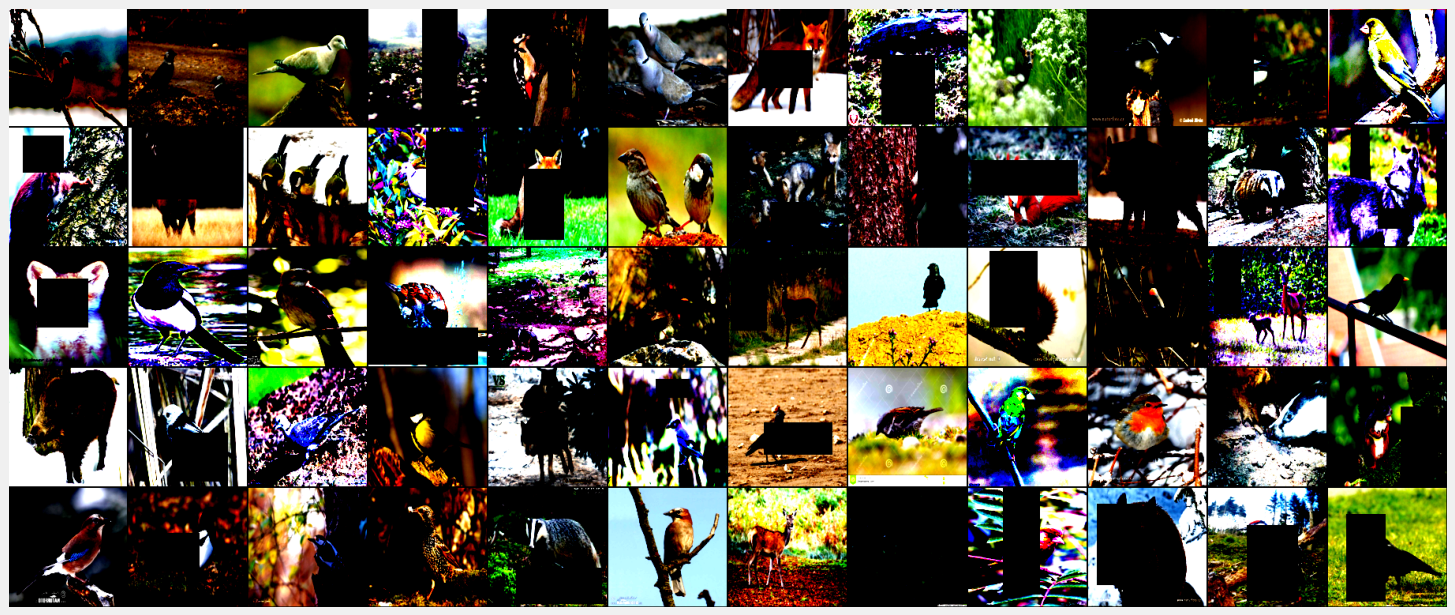

In [ ]:
def show_augmentation(data_loader):
    for imgs, labels in data_loader:  
        fig, ax = plt.subplots(figsize = (23, 23)) 
        ax.set_xticks([]); ax.set_yticks([]) 
        ax.imshow(make_grid(imgs[:60], nrow = 12).permute(1, 2, 0))     
        break
        
show_augmentation( trainloader )

# Model summary

In [ ]:
model_stats = summary( model=model, input_size=hparams["Input_shape"], verbose=1, col_width=18, 
        col_names=[ "kernel_size", "input_size", "output_size", "num_params", "mult_adds" ], 
        row_settings=["var_names"],
         )

summary_str = str(model_stats)

Layer (type (var_name))                  Kernel Shape       Input Shape        Output Shape       Param #            Mult-Adds
ConvNet (ConvNet)                        --                 [1, 3, 150, 150]   [1, 21]            --                 --
├─Sequential (conv_layers)               --                 [1, 3, 150, 150]   [1, 64, 18, 18]    --                 --
│    └─Conv2d (0)                        [3, 3]             [1, 3, 150, 150]   [1, 64, 150, 150]  1,792              40,320,000
│    └─BatchNorm2d (1)                   --                 [1, 64, 150, 150]  [1, 64, 150, 150]  128                128
│    └─ReLU (2)                          --                 [1, 64, 150, 150]  [1, 64, 150, 150]  --                 --
│    └─MaxPool2d (3)                     [2, 2]             [1, 64, 150, 150]  [1, 64, 75, 75]    --                 --
│    └─Conv2d (4)                        [3, 3]             [1, 64, 75, 75]    [1, 128, 75, 75]   73,856             415,440,000
│    └─BatchNor

In [ ]:
# # Saving the architecture to a txt file:
# from contextlib import redirect_stdout

# with open(f'./{model_name}_arch.txt', 'w') as f:
#     with redirect_stdout(f):
#         print(model_stats)


# run[f"model/{model_name}_arch"].upload(f"./{model_name}_arch.txt")
# run[f"model/artifacts/{model_name}_arch"].track_files(f"./{model_name}_arch.txt")

# run[f"model/artifacts/{hparams}"] = hparams

In [ ]:
# # artifacts
# # source_code

# files = [ 'data_wrangling', 'image_preprocessing', 'train_model', 'model_testing', 'model_convnet', 'data_transforms' ]

# for file_name in files:
#   run[f"source_code/artifacts/{file_name}"].track_files(f"./{file_name}.py")

# Train model

## Train data

In [ ]:
intel_img_cls_params = {}

intel_img_cls_params['model']         = model
intel_img_cls_params['criterion']     = criterion
intel_img_cls_params['optimizer']     = optimizer
intel_img_cls_params['lr_scheduler']  = lr_scheduler
intel_img_cls_params['num_epochs']    = hparams['n_epochs']
intel_img_cls_params['dataloaders']   = data_wrangling_obj.dataloaders
intel_img_cls_params['dataset_sizes'] = data_wrangling_obj.dataset_sizes
intel_img_cls_params['class_names']   = data_wrangling_obj.class_names
intel_img_cls_params['device']        = device
              
                  
intel_image_cls = TrainModel( **intel_img_cls_params )

In [ ]:
intel_image_cls.train_model()

In [ ]:
intel_image_cls.metrics_df

In [ ]:
stats_df_copy = intel_image_cls.metrics_df
stats_df_copy.set_index('epoch', inplace=True)

stats_df_copy.head()

,train_loss,val_loss,train_acc,val_acc,train_acc_macro,val_acc_macro,train_f1_macro,val_f1_macro,train_precision_macro,val_precision_macro,train_recall_macro,val_recall_macro
epoch,,,,,,,,,,,,
1,5.105401,3.011853,0.055247,0.073333,0.055247,0.073333,0.043379,0.027975,0.050984,0.031380,0.055247,0.073333
2,2.974364,2.828103,0.079982,0.119048,0.079982,0.119048,0.050693,0.048261,0.056891,0.050768,0.079982,0.119048
3,2.939223,2.828378,0.084142,0.111429,0.084142,0.111429,0.063538,0.060451,0.077883,0.056074,0.084142,0.111429
4,2.906738,2.696122,0.084836,0.133333,0.084836,0.133333,0.061551,0.073245,0.070097,0.058699,0.084836,0.133333
5,2.853855,2.717188,0.104716,0.124762,0.104716,0.124762,0.081766,0.060898,0.106459,0.045648,0.104716,0.124762


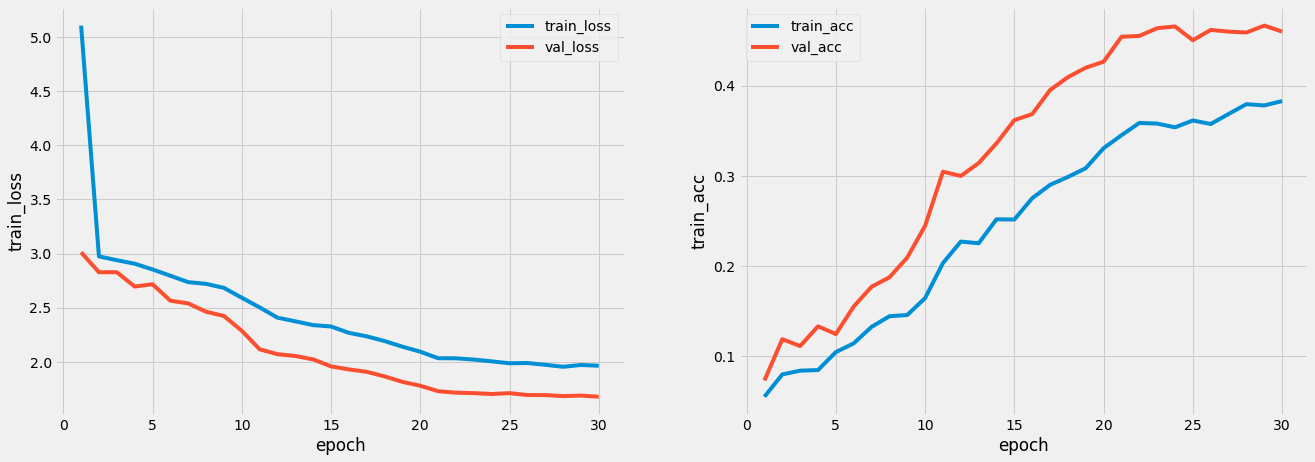

In [ ]:
col_idx = 0
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))


for i, col in enumerate(stats_df_copy.columns[:4]):
  g = sns.lineplot(data=stats_df_copy[col], dashes=False, label=col, ax=ax[col_idx] )
  if i == 1:
    col_idx=1

plt.legend()
plt.show()

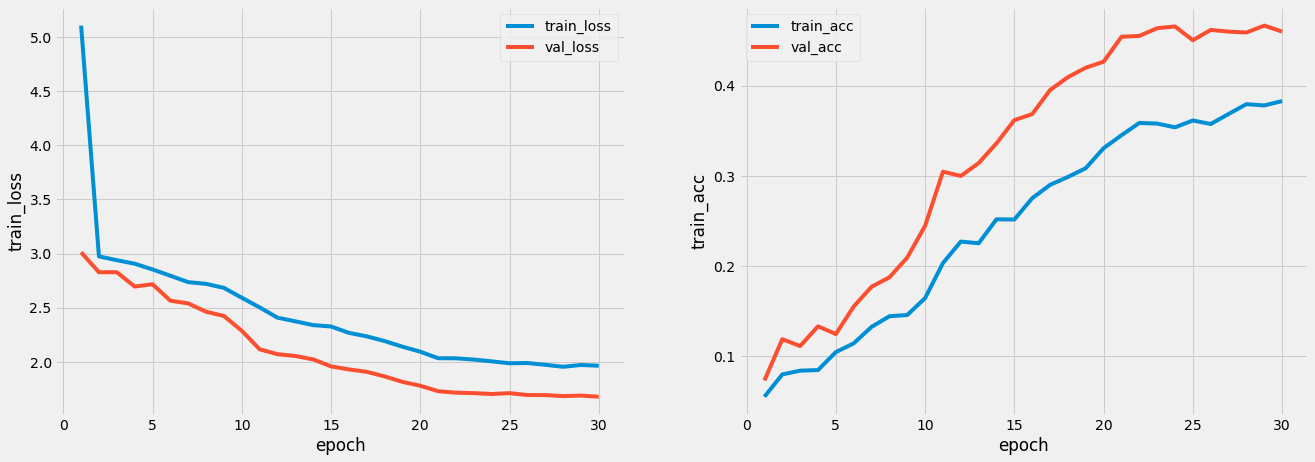

In [ ]:
col_idx = 0
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))


for i, col in enumerate(stats_df_copy.columns[:4]):
  g = sns.lineplot(data=stats_df_copy[col], dashes=False, label=col, ax=ax[col_idx] )
  if i == 1:
    col_idx=1

plt.legend()
plt.show()

In [ ]:
import gc

intel_image_cls.model.cpu()
del intel_image_cls.model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# # Pandas DataFrame 
# run['metrics/train_val_loss_acc'].upload(File.as_html(intel_image_cls.metrics_df))

In [ ]:
# save the trained model to disk

best_model_path = os.path.join(path_to_db, 'bestModel.pth')

torch.save({
            'epoch': hparams['n_epochs'],
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion, 
            }, 
           best_model_path, 
           )
 


# run['model/model_dict'].upload('./ConvNet.pth')

# Test model

## Model load

In [ ]:
model = ConvNet( in_channels=3, n_classes=21, model_arch=model_arch['arch1'] )
model.load_state_dict( torch.load( best_model_path )['model_state_dict']  )

In [ ]:
model = ConvNet(in_channels=3, n_classes=21, model_arch=model_arch['arch1'])
model.load_state_dict( torch.load('/content/drive/MyDrive/ColabNotebooks/Projects/AnimalsDetection/best.pt',
                                  map_location=torch.device('cpu'))['model_state_dict']  )

In [ ]:
model.to(device)    

## confusion matrix

In [ ]:
data_wrangling_obj.image_datasets['val']

Dataset ImageFolder
    Number of datapoints: 1050
    Root location: /content/datasets/ValSize_20_TestSize_2/val
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(150, 150))
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )

In [ ]:
valloader = data_wrangling_obj.dataloaders['val']
len( valloader )

17

In [ ]:
data_wrangling_obj.dataset_sizes['val']

1050

In [ ]:
myDataset

'/content/datasets/ValSize_20_TestSize_2'

In [ ]:
test_model_params = { 
                     
                     'data_loader' : valloader,
                     'class_names' : cls_names,
                     'dir_path'    : os.path.join(myDataset, 'test', 'test'), 
                     'data_size'   : data_wrangling_obj.dataset_sizes['val']
                     }



test_model = ModelTesting( **test_model_params  )

In [ ]:
test_model.dir_path

'/content/datasets/ValSize_20_TestSize_2/test/test'

In [ ]:
%%time
test_model.check_accuracy()

Accuracy of the network on the 1050 val images: 46.381%
CPU times: user 10.4 s, sys: 114 ms, total: 10.6 s
Wall time: 10.6 s


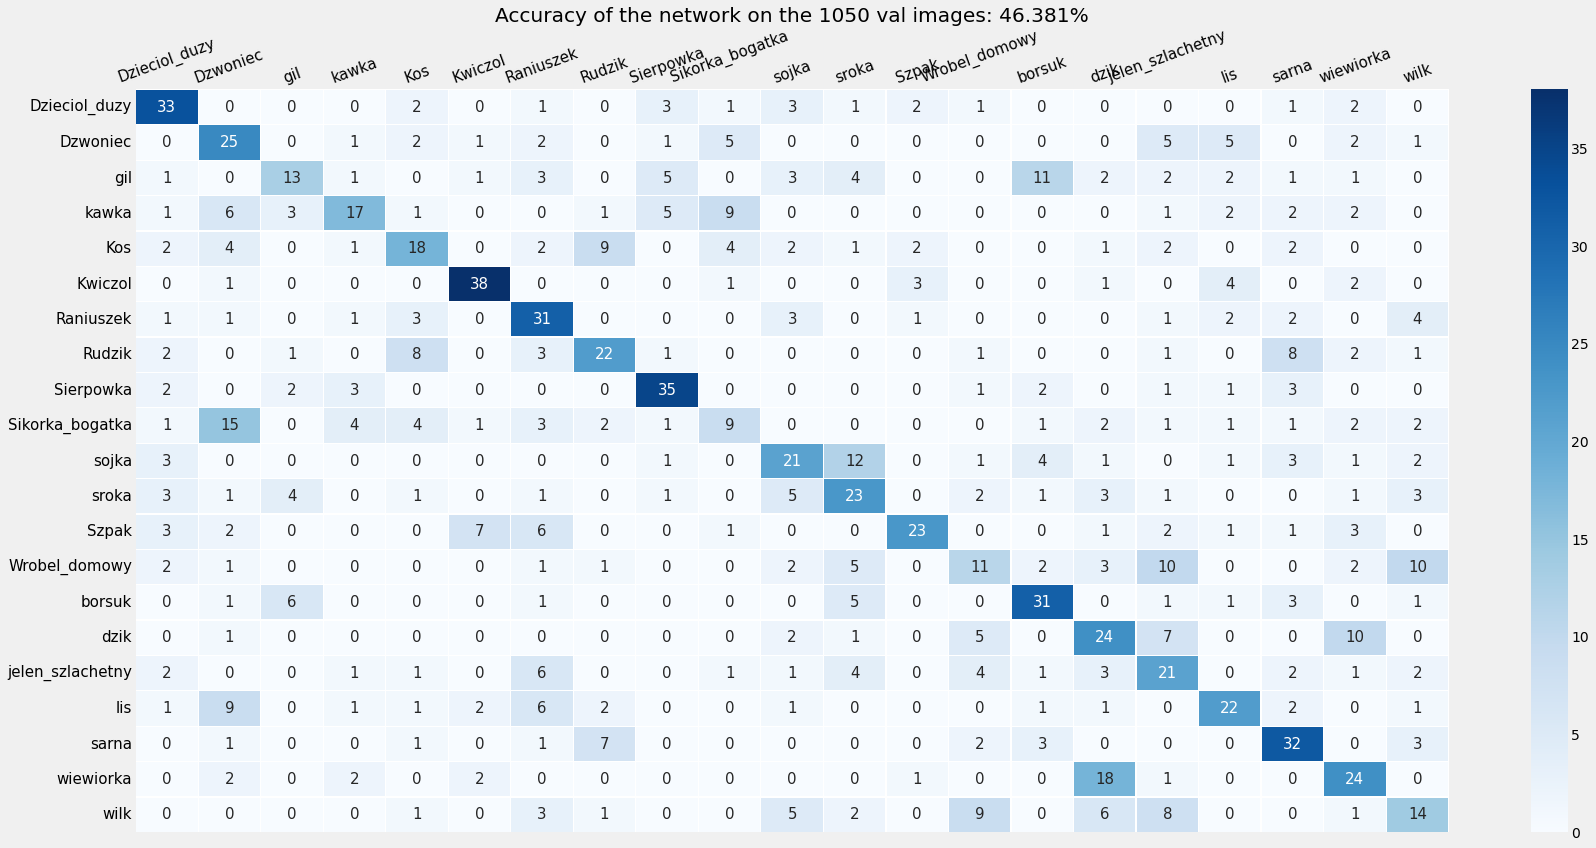

CPU times: user 12 s, sys: 543 ms, total: 12.5 s
Wall time: 12.2 s


In [ ]:
%%time
test_model.create_confusion_matrix(figsize=(25, 12))

## Test model on new data

In [ ]:
%%time
test_model.model_testing()

CPU times: user 662 ms, sys: 4 ms, total: 666 ms
Wall time: 675 ms


In [ ]:
test_model.dir_path

'/content/datasets/ValSize_20_TestSize_2/test/test'

In [ ]:
no_imgs = len([img for img in os.listdir(test_model.dir_path)])
no_imgs

42

In [ ]:
visualize_imgs_params = { 
                          'number_of_images' : no_imgs,
                          'no_rows'          : 7,
                          'no_cols'          : 6,
                          'set_figsize'      : (21,18),
                          'save_to_path'     : os.path.join(myDataset, 'prediction_results.jpg'),
                          'pred_dict'        : test_model.pred_dict,
                        }



test_model.visualize_n_random_images( **visualize_imgs_params)